# Convolutions & Filters

## Initialization

In [22]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

from matplotlib.colors import NoNorm

In [23]:
# convenience function that estimates the difference between 2 images
def diffscore(img1, img2):
    return np.sum(abs(img1-img2))

# convenience function to draw 1 image - no typing 4 lines anymore
def display(img, single_layer = False):
    plt.figure()
    plt.axis("off")
    if single_layer:
        plt.imshow(img,cmap='gray',norm=NoNorm())
        # this ensures plt doesn't treat our grayscale array as a messed-up 3-channel image
    else:
        plt.imshow(img)
    plt.show()

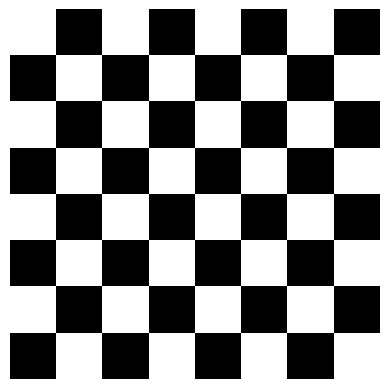

(64, 64)


In [24]:
whereblack = [[bool((j+i%2)%2) for j in range(8)] for i in range(8)]

checkerboard1 = (np.where(whereblack, 0, 255)).astype(np.uint8)
checkerboard8 = cv2.resize(checkerboard1, dsize=None, fx=8, fy=8, interpolation=cv2.INTER_NEAREST)

display(checkerboard8, single_layer=True)
print(checkerboard8.shape)

## Simple Convolutions

Convolutions (and correlations, almost the same thing) are yet another important tool for image processing.

When working with opencv libraries, convolution matrices (aka kernels) are represented with 2D arrays.

An example of kernel creation on the identity kernel; it changes nothing whatsoever, but the name might come up.

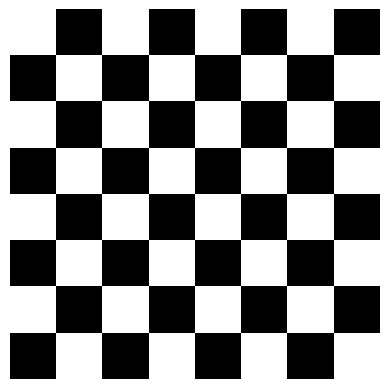

In [25]:
identity_kernel = np.array([[0,0,0],
                            [0,1,0],
                            [0,0,0]])
identity = cv2.filter2D(src=checkerboard8, ddepth=-1, kernel=identity_kernel)
display(identity, single_layer=True)

All of the convolutions below can be found in lectures

#### Box filter kernel (5 points)

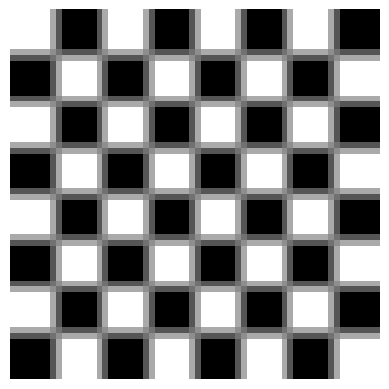

In [26]:
box_kernel = np.full((3,3),1/9)
display(cv2.filter2D(src=checkerboard8, ddepth=-1, kernel=box_kernel), single_layer=True)

#### Weighted filter kernel (5 points)

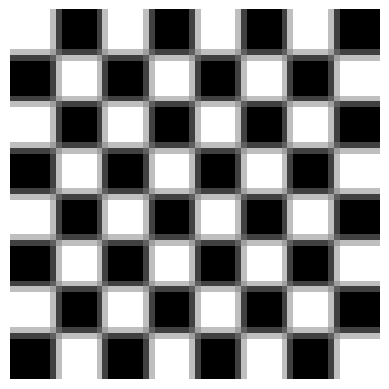

In [27]:
weighted_smooth_kernel = np.array([[1,2,1],
                                   [2,4,2],
                                   [1,2,1]])/16
display(cv2.filter2D(src=checkerboard8, ddepth=-1, kernel=weighted_smooth_kernel), single_layer=True)

#### Laplacian Edge Detection (5 points)

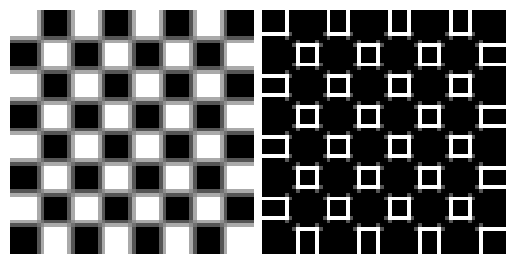

In [28]:
sharpen_kernel = np.array([[-1,-1,-1],
                           [-1,8,-1],
                           [-1,-1,-1]])
checkerboard8_blur = cv2.blur(checkerboard8, ksize = (3,3))
edges = cv2.filter2D(src=checkerboard8_blur, ddepth=-1, kernel=sharpen_kernel)
result = np.concatenate((checkerboard8_blur, np.full((64, 2), 255), edges), axis=1)
display(result, single_layer=True)

#### Sobel Edge Detection (5 points)

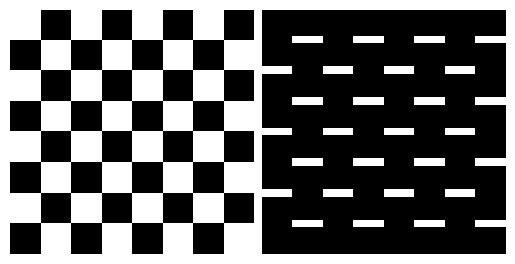

In [29]:
sobel_kernel = np.array([[-1,-2,-1],
                         [0,0,0],
                         [1,2,1]])
edges = cv2.filter2D(src=checkerboard8, ddepth=-1, kernel=sobel_kernel)
result = np.concatenate((checkerboard8, np.full((64, 2), 255), edges), axis=1)
display(result, single_layer=True)

## Filters

Filters are yet another important tool, good for image de-noising and sharpening.

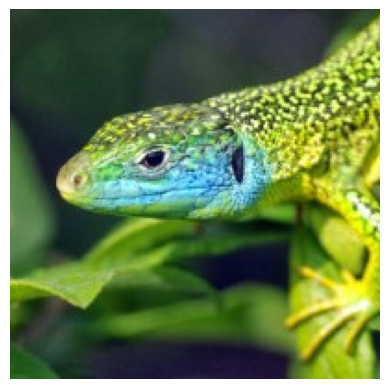

In [30]:
src = cv2.cvtColor(cv2.imread("src.jpg"), cv2.COLOR_BGR2RGB)
display(src)

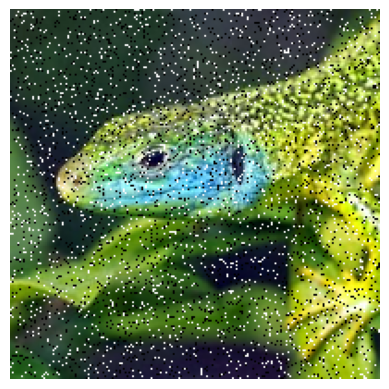

In [31]:
# noising the image up
import random
def pepper_salt(img):
    out = img.copy()
    random_mat = np.array([[random.randint(0, 255) for j in range(img.shape[1])] for i in range(img.shape[0])])
    pepper_mat = random_mat<16
    pepper_mat = np.stack((pepper_mat,pepper_mat,pepper_mat), axis=2)
    salt_mat = random_mat>242
    salt_mat = np.stack((salt_mat,salt_mat,salt_mat), axis=2)
    
    out = np.where(pepper_mat, 0, out)
    out = np.where(salt_mat, 255, out)
    return out

src_ps = pepper_salt(src)
display(src_ps)

A widely used smoothing filter is the Gaussian filter:

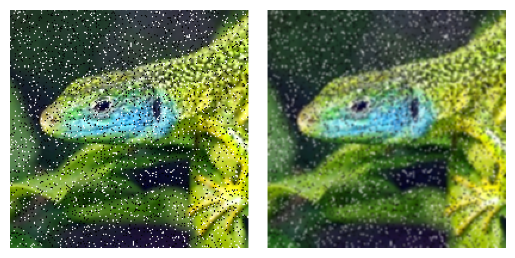

In [32]:
gauss_sbs = np.concatenate(
    (src_ps,
    np.full((src.shape[0], 16, 3), 255),
    cv2.GaussianBlur(src=src_ps, ksize=(3,3), sigmaX=0)),
    axis = 1
)
display(gauss_sbs)

One other important smoothing filter is the Bilateral filter:

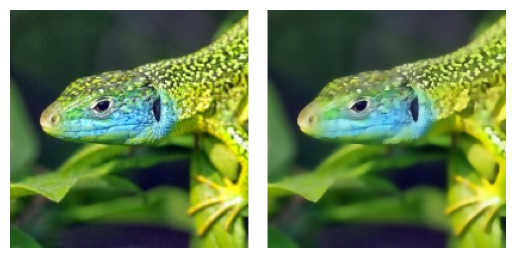

In [33]:
bilat_sbs = np.concatenate(
    (src,
    np.full((src.shape[0], 16, 3), 255),
    cv2.bilateralFilter(src, d=7, sigmaColor=100, sigmaSpace=100)),
    axis = 1
)

display(bilat_sbs)

But to noise a-la salt and pepper, the best answer is the Median filter:

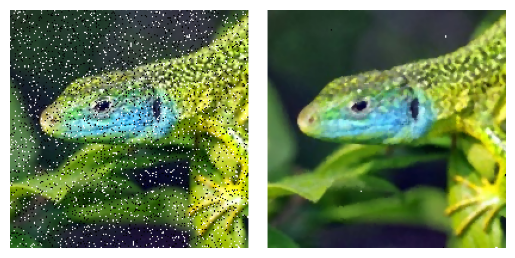

In [34]:
median_sbs = np.concatenate(
    (src_ps,
    np.full((src.shape[0], 16, 3), 255),
    cv2.medianBlur(src_ps, ksize=3)),
    axis = 1
)

display(median_sbs)

#### Median Filter (25 points)

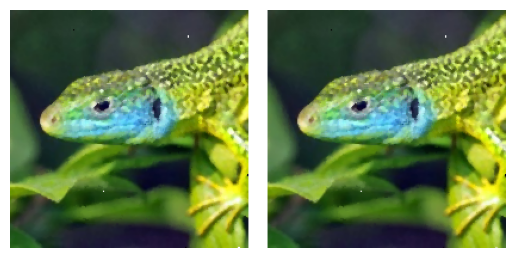

116457


In [35]:
def your_median_filter(img, ksize):
    out = img.copy()
    # for i in range(img.shape[0]):
    #     for j in range(img.shape[1]):
    #         coeff = (ksize-1)//2
    #         neighbourhood = img[max(0,i-coeff):min(i+coeff+1,img.shape[0]), max(0,j-coeff):min(j+coeff+1,img.shape[1]),:]
    #         val_lookup = dict()
    #         for xn in range (ksize):
    #             for yn in range(ksize):
    #                 pixel = neighbourhood[xn][yn]
    #                 gs = np.sum (pixel) /3
    #                 if gs not in val_lookup:
    #                     val_lookup[gs] = []
    #                     val_lookup[gs].append(pixel)
    #         vals = list (val_lookup)
    #         vals.sort()
    #         pixel_opts = val_lookup[vals[int((ksize**2)/2)]]
    #         wanted_pixel = pixel_opts[0]
    #         out[i][j] = wanted_pixel


    coeff = (ksize-1)//2
    for x in range (img.shape[0]):
        for y in range (img.shape[1]):
            neighbourhood = img[max(0,x-coeff):min(x+coeff+1, img.shape[0]),
                                max(0, y-coeff):min(y+coeff+1, img.shape[1]), :]
            
            for channel in range(3):
                wanted = np.median(neighbourhood[:,:,channel])
                out[x][y][channel] = wanted


    # coeff = (ksize-1)//2
    # for i in range(coeff, img.shape[0]-coeff):
    #     for j in range(coeff, img.shape[1]-coeff):
    #         neighbourhood = img[i-coeff:i+coeff+1, j-coeff:j+coeff+1]
    #         median_idx = neighbourhood.shape[0]*neighbourhood.shape[1]//2
    #         vals = []
    #         for channel in range(3):
    #             channel_vals = neighbourhood[:,:,channel].flatten()
    #             channel_vals.sort()
    #             vals.append(channel_vals[median_idx])
    #         out[i,j] = np.array([vals[0], vals[1], vals[2]])

    return out

comp_median_sbs = np.concatenate(
    (cv2.medianBlur(src_ps, ksize=3),
    np.full((src.shape[0], 16, 3), 255),
    your_median_filter(src_ps, ksize=3)),
    axis = 1
)

display(comp_median_sbs)
print(diffscore(cv2.medianBlur(src_ps, ksize=3), your_median_filter(src_ps, ksize=3)))

## Pattern Detection (there's convolutions inside)

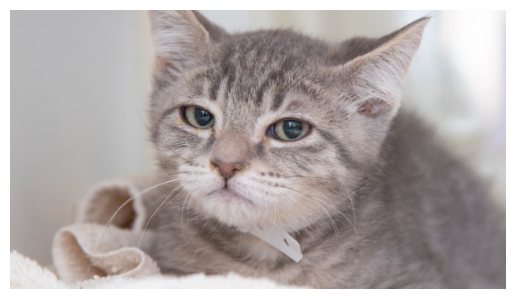

(360, 640, 3)

In [36]:
src2 = cv2.cvtColor(cv2.imread("src2.jpg"), cv2.COLOR_BGR2RGB)
display(src2)
src2.shape

cv2.matchTemplate searches for the point where the difference is lowest:

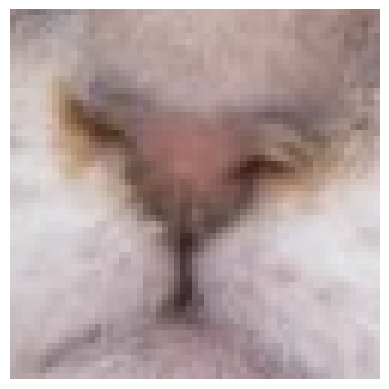

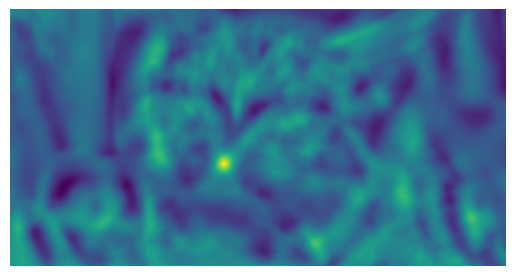

In [37]:
template = src2[180:241, 250:311]
display(template)

res = cv2.matchTemplate(src2,template,cv2.TM_CCOEFF_NORMED)
display(res)

#### Simple Pattern Matching (10 points)

Try to match both of the cat's eyes at the same time, and draw rectangles around the match points.

tip: Find locations of highest/lowest intensity with
``` min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res) ```

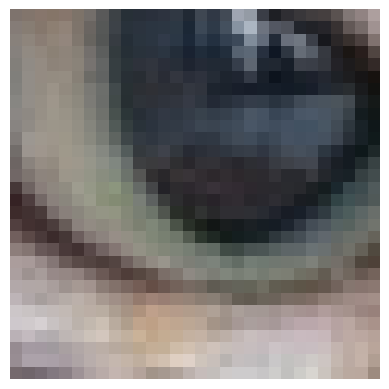

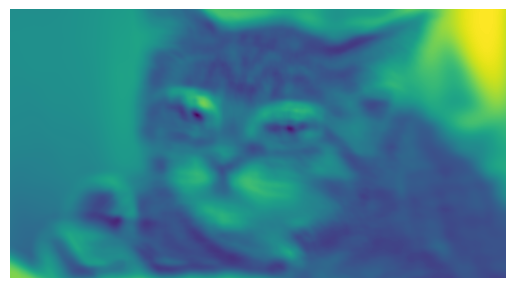

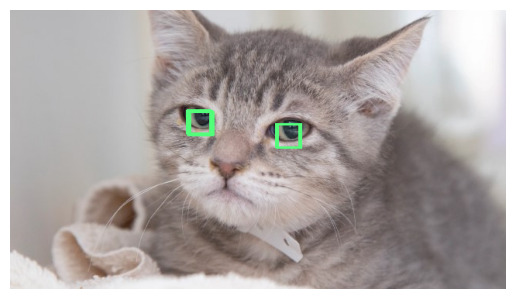

In [48]:
# # # out = src2.copy()
# # # template = src2[128:151, 235:261]
# # # h, w = template.shape[:2]

# # # display(template)
# # # gray = cv2.cvtColor(out, cv2.COLOR_BGR2GRAY)
# # # template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
# # # res1 = cv2.matchTemplate(gray, template, cv2.TM_CCOEFF_NORMED)
# # # template_flipped = cv2.flip(template, 1)
# # # res2 = cv2.matchTemplate(gray, template_flipped, cv2.TM_CCOEFF_NORMED)
# # # res = np.maximum(res1, res2)
# # # threshold = 0.6
# # # locs = np.where(res >= threshold)
# # # for i in zip(*locs[::-1]):
# # #     cv2.rectangle(out, i, (i[0] + w, i[1] + h), (255, 255, 255), 1)

# # # display(res)
# # # display (out)


# #res = cv2.matchTemplate(src2,template,cv2.TM_SQDIFF_NORMED)
# # res = cv2.matchTemplate(out, template, cv2.TM_CCOEFF_NORMED)
# # threshold = 0.6
# # loc = np.where(res >= threshold)

# # #res = cv2.matchTemplate(src2,template,cv2.TM_CCOEFF_NORMED)


# # for i in zip(*loc[::-1]):
# #     cv2.rectangle(out, i, (i[0] + w, i[1] + h), (255, 255, 255), 1)


# # min_val,max_val, min_loc, max_loc = cv2.minMaxLoc(res)

# #display(cv2.rectangle(src2.copy(), (min_loc[0]-15, min_loc[1]-15), (min_loc[0]+30, min_loc[1]+30), (255,255,255), 2))


out = src2.copy()
template = src2[130:160, 230:260]
display(template)

res = cv2.matchTemplate(src2, template, cv2.TM_SQDIFF_NORMED)
display(res)
eye_loc = res < 0.08
rc, gc, bc = src2[:,:,0], src2[:,:,1], src2[:,:,2]
# rc_out = np.where(eye_loc, 255, rc)
# gc_out = np.where(eye_loc, 0, gc)
# bc_out = np.where(eye_loc, 0, bc)
#display(np.stack(rc_out, gc_out, bc_out),axis =2)

x_coeff = 15
y_coeff = 15

for x in range(res.shape[0]):
    for y in range (res.shape[1]):
        if eye_loc[x][y]:
        #     out[x+x_coeff][y+y_coeff] = [255,0,0]
            out = cv2.rectangle(out, (y, x),(y+2*y_coeff, x+2*x_coeff),(81,255,123), 1)

display(out)

# Homework

#### Edge detection (30 points)

Draw lines (highlight) in your preferred color around as many edges as you can in the image loaded below. Will be graded based on how many edges are outlined.

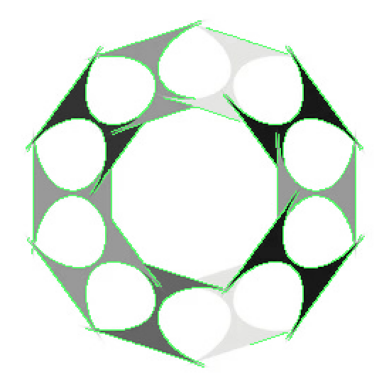

In [39]:
hw1 = cv2.cvtColor(cv2.imread("hw1.jpg"), cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(hw1, cv2.COLOR_RGB2GRAY)
edges = cv2.Canny(gray, 100, 200)
contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for contour in contours:
    cv2.polylines(hw1, [contour], True, (82, 255, 102), thickness=1)

display(hw1)

#### Simple Pattern Matching (15 points)

Implement your own pattern matching function. You're advised to consider convolutions, but mostly you need it to work. Will be graded based on solution robustness (starting at the likes of ```template == src[x:x2,y:y2]``` graded at 1 point).

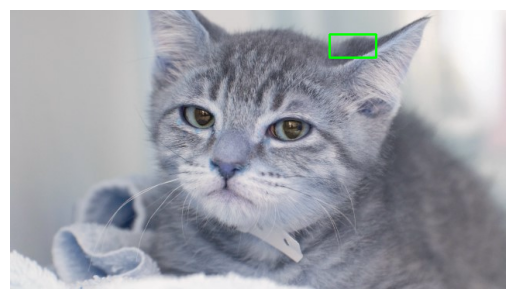

In [49]:
def your_matching(img, template):
    '''working'''
    # # # if isinstance(img, str):
    # # #     img = cv2.imread(img, cv2.IMREAD_COLOR)

    # # # out = img.copy()
    
    # # # if len(img.shape) == 3:
    # # #     img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # # # else:
    # # #     img_gray = img

    # # # if isinstance(template, str):
    # # #     template = cv2.imread(template, cv2.IMREAD_COLOR)

    # # # if len(template.shape) == 3:
    # # #     template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    # # # else:
    # # #     template_gray = template
    
    # # # corr = cv2.matchTemplate(img_gray, template_gray, cv2.TM_CCOEFF_NORMED)
    # # # min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(corr)
    # # # h, w = template_gray.shape
    # # # top_left = max_loc
    # # # bottom_right = (top_left[0] + w, top_left[1] + h)
    # # # cv2.rectangle(out, top_left, bottom_right, (81, 255, 123), 2)


    '''almost working'''
    # out = cv2.imread(img, 0)
    # img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    # template = cv2.imread(template, cv2.IMREAD_GRAYSCALE)
    
    # template_flipped = np.flip(np.flip(template, axis=0), axis=1)

    # img_height, img_width = img.shape[:2]
    # template_height, template_width = template.shape[:2]
    
    # correlation = np.zeros((img_height-template_height+1, img_width-template_width+1))

    # for i in range(template_height):
    #     for j in range(template_width):
    #         correlation += np.multiply(img[i:i+(img_height-template_height+1),j:j+(img_width-template_width+1)], template_flipped[i,j])
            
    # max_loc = np.unravel_index(np.argmax(correlation), correlation.shape)
    # #cv2.rectangle(out, (330, 135), (392, 170), (255,255,255), 2)
    
    # cv2.rectangle(out, max_loc[::-1], (max_loc[1]+template_width,max_loc[0]+template_height), (255,255,255), 2)
    # print(max_loc[::-1], (max_loc[1]+template_width,max_loc[0]+template_height))

    '''almost working'''
    out = cv2.imread(img)
    template = cv2.imread(template)

    img_height, img_width = out.shape[:2]
    template_height, template_width = template.shape[:2]

    # Pad the input image so that it can be fully covered by the template
    img_padded = cv2.copyMakeBorder(out, 0, template_height - 1, 0, template_width - 1, cv2.BORDER_CONSTANT, value=0)

    # Flip the template
    template_flipped = cv2.flip(template, -1)

    correlation = np.zeros((img_height, img_width))

    # Calculate the correlation
    for i in range(template_height):
        for j in range(template_width):
            for k in range(out.shape[2]):
                correlation += cv2.matchTemplate(img_padded[:,:,k], template_flipped[:,:,k], cv2.TM_CCORR_NORMED)

    # Find the location with the maximum correlation
    max_loc = np.unravel_index(np.argmax(correlation), correlation.shape)

    # Draw the rectangle around the template
    cv2.rectangle(out, max_loc[::-1], (max_loc[1]+template_width,max_loc[0]+template_height), (0,255,0), 2)


    
    return out

display(your_matching("src2.jpg", "templ.jpg"))